In [2]:
import numpy as np
import matplotlib.pyplot as plt
from patchify import patchify
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torchvision import models

from utils.data_utils import load_tomogram
from model import UNet3D_module

In [ ]:
#---- test --- 

In [22]:
mask = load_tomogram("/home/haicu/ye.liu/data/cryoET/onlyactin/tomo_lbls_0.mrc") #filtered version, only has 0,1 labels
#mask = load_tomogram("/home/haicu/ye.liu/data/cryoET/onlyactin/tomo_den_0.mrc") #
tomo = load_tomogram("/home/haicu/ye.liu/data/cryoET/onlyactin/tomo_rec_0_snr1.7.mrc")

Loading tomogram: /home/haicu/ye.liu/data/cryoET/onlyactin/tomo_lbls_0.mrc
Loading tomogram: /home/haicu/ye.liu/data/cryoET/onlyactin/tomo_rec_0_snr1.7.mrc


In [23]:
patch_mask = patchify(mask,(64,64,64),step=32)
patch_tomo = patchify(tomo,(64,64,64),step=32)
input_mask = np.reshape(patch_mask, (-1, patch_mask.shape[3], patch_mask.shape[4], patch_mask.shape[5]))
input_tomo = np.reshape(patch_tomo, (-1, patch_tomo.shape[3], patch_tomo.shape[4], patch_tomo.shape[5]))

In [5]:
# test: not enough RAM (16G), not needed for 64G RAM
# patch_mask = patch_mask[:2,:10,:10,:,:,:]
# patch_tomo = patch_tomo[:2,:10,:10,:,:,:]

In [24]:
patch_mask.shape

(6, 30, 30, 64, 64, 64)

In [25]:
input_mask.shape

(5400, 64, 64, 64)

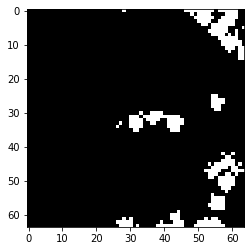

In [26]:
plt.imshow(patch_mask[1,1,1,:,:,10],cmap='gray')

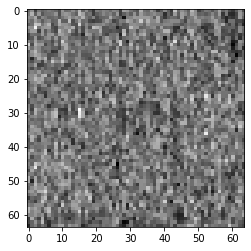

In [27]:
plt.imshow(patch_tomo[1,1,1,:,:,10],cmap='gray')

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(input_tomo, input_mask, test_size = 0.10)

In [8]:
model = UNet3D_module(64,1,2)

In [45]:
input_tomo.shape

(5400, 64, 64, 64)

In [14]:
y_train.shape

(4860, 64, 64, 64)

In [30]:
X_train[1].shape

(64, 64, 64)

In [31]:
X_train[1][np.newaxis, :,:, :].shape

(1, 64, 64, 64)

In [12]:
# test
test = X_train[1][np.newaxis, np.newaxis, :,:, :]
model(torch.tensor(test))

tensor([[[[[0.5446, 0.5440, 0.5649,  ..., 0.5310, 0.5210, 0.5444],
           [0.5725, 0.5753, 0.6047,  ..., 0.5653, 0.5381, 0.5372],
           [0.5707, 0.5639, 0.5516,  ..., 0.5517, 0.5351, 0.5312],
           ...,
           [0.5628, 0.5858, 0.5611,  ..., 0.5279, 0.5319, 0.5453],
           [0.5568, 0.6010, 0.5328,  ..., 0.5632, 0.5377, 0.5336],
           [0.5569, 0.5534, 0.5676,  ..., 0.5552, 0.5547, 0.5494]],

          [[0.5540, 0.5414, 0.5465,  ..., 0.5327, 0.5198, 0.5508],
           [0.5044, 0.6164, 0.4772,  ..., 0.5241, 0.5039, 0.5709],
           [0.5390, 0.5430, 0.5494,  ..., 0.5353, 0.5268, 0.5410],
           ...,
           [0.5178, 0.5662, 0.5453,  ..., 0.5578, 0.5310, 0.5602],
           [0.5459, 0.5617, 0.5503,  ..., 0.5707, 0.5238, 0.5638],
           [0.5357, 0.5651, 0.5409,  ..., 0.5277, 0.5342, 0.5587]],

          [[0.5525, 0.5341, 0.5193,  ..., 0.5683, 0.5502, 0.5605],
           [0.5940, 0.7015, 0.6255,  ..., 0.6109, 0.5804, 0.5845],
           [0.5516, 0.5114

In [3]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


In [4]:
# patch_size, input channel, output channel(greyscale -> #num of channel =1)
model = UNet3D_module((64,64,64),1,1)

In [12]:
# Dataset
from torch.utils.data import Dataset

class Sim_CET(Dataset):
    def __init__(self,img_path, mask_path, patch_size, num_patches):
        self.img_path = img_path
        self.mask_path = mask_path
        self.patch_size = patch_size
        self.num_patches = num_patches
        self.img = load_tomogram(self.img_path)
        self.mask = load_tomogram(self.mask_path)
        
    def __len__(self):
        return self.num_patches
    
    def __getitem__(self, idx:int):
        img_patches = patchify(self.img, self.patch_size, step = self.patch_size[0]//2)
        mask_patches = patchify(self.mask, self.patch_size, step = self.patch_size[0]//2)
        
        input_mask = np.reshape(mask_patches, (-1, mask_patches.shape[3], mask_patches.shape[4], mask_patches.shape[5]))
        input_tomo = np.reshape(img_patches, (-1, img_patches.shape[3], img_patches.shape[4], img_patches.shape[5]))
        
        return (input_tomo[idx-1][np.newaxis, :,:, :],input_mask[idx-1][np.newaxis, :,:, :])

In [13]:
mask_path = "/home/haicu/ye.liu/data/cryoET/onlyactin/tomo_lbls_0.mrc"
img_path = "/home/haicu/ye.liu/data/cryoET/onlyactin/tomo_rec_0_snr1.7.mrc"
patch_size = (64,64,64)
num_patches = 6*30*30

In [14]:
dataset = Sim_CET(img_path, mask_path, patch_size, num_patches)
train_loader = DataLoader(dataset, batch_size =4)

Loading tomogram: /home/haicu/ye.liu/data/cryoET/onlyactin/tomo_rec_0_snr1.7.mrc
Loading tomogram: /home/haicu/ye.liu/data/cryoET/onlyactin/tomo_lbls_0.mrc


In [15]:
# helper function
def train(train_loader, model):
    running_loss = 0.0
    data_size = len(dataset)
    model.train()
    i=0
    for inputs, masks in train_loader:
        inputs, masks = inputs.to(device), masks.to(device)
        optimizer.zero_grad()
        i+=1

#     with torch.set_grad_enabled(True):
        logit = model(inputs)
        loss = nn.BCEWithLogitsLoss()(logit.squeeze(1), masks.squeeze(1))
        loss.backward()
        optimizer.step()
        if i ==50: break

    running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / data_size
    print("---",running_loss,"----")
    
    return epoch_loss

In [ ]:
# Setup parameters
n_fold = 5
pad_left = 27
pad_right = 27
fine_size = 202
batch_size = 2
epoch = 3 #300 
snapshot = 6 
max_lr = 0.012 
min_lr = 0.001 
momentum = 0.9 
weight_decay = 1e-4 

# Setup optimizer
scheduler_step = epoch // snapshot
optimizer = torch.optim.SGD(model.parameters(), lr=max_lr, momentum=momentum, weight_decay=weight_decay)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, scheduler_step, min_lr)

num_snapshot = 0
best_acc = 0

for epoch_ in range(epoch):
    train_loss = train(train_loader, model)
#     val_loss, accuracy = test(val_loader, salt)
#     lr_scheduler.step()
    
#     if accuracy > best_acc:
#         best_acc = accuracy
#         best_param = model.state_dict()

#     if (epoch_ + 1) % scheduler_step == 0:
#         torch.save(best_param, save_weight + weight_name + str(idx) + str(num_snapshot) + '.pth')
#         optimizer = torch.optim.SGD(model.parameters(), lr=max_lr, momentum=momentum, weight_decay=weight_decay)
#         lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, scheduler_step, min_lr)
#         num_snapshot += 1
#         best_acc = 0
        
    print('epoch: {} train_loss: {:.3f}'.format(epoch_ + 1, train_loss))

#     print('epoch: {} train_loss: {:.3f} val_loss: {:.3f} val_accuracy: {:.3f}'.format(epoch_ + 1, train_loss, val_loss, accuracy))

--- 3.2469780445098877 ----
epoch: 1 train_loss: 0.001
--- 2.9636313915252686 ----
epoch: 2 train_loss: 0.001
